In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import time
from dataset_PA1.dataloader import Dataloader
from dataset_PA1.dataloader import datasetIterator

random.seed(42)

In [2]:
class LinearLayer:
    def __init__(self, batch_size, input_size, output_size, learning_rate=0.001):
        self.batch_size = batch_size
        self.input_size = input_size
        self.output_size = output_size
        self.learning_rate = learning_rate

        limit = np.sqrt(6 / (input_size + output_size))
        self.weights = np.random.uniform(-limit, limit, (input_size, output_size))
        self.biases = np.zeros((1, output_size))

        self.dweights = np.zeros_like(self.weights)
        self.dbiases = np.zeros_like(self.biases)

    def forward(self, x):
        self.input = x
        output = np.dot(x, self.weights) + self.biases
        return output

    def backward(self, dvalues):
        self.dinput = np.dot(dvalues, self.weights.T)
        self.dweights = np.dot(self.input.T, dvalues) / self.batch_size
        self.dbiases = np.sum(dvalues, axis=0) / self.batch_size
        return self.dinput
    
    def update_params(self):
        self.weights -= self.learning_rate * self.dweights
        self.biases -= self.learning_rate * self.dbiases

class ReLULayer:
    def __init__(self):
        pass
    
    def forward(self, x):
        self.input = x
        output = np.maximum(0, x)
        return output
    
    def backward(self, dvalues):
        self.dinput = dvalues.copy()
        self.dinput[self.input < 0] = 0
        return self.dinput

def softmax(x):
    exp_real = np.exp(x - np.max(x, axis=1, keepdims=True))
    pred = exp_real / np.sum(exp_real, axis=1, keepdims=True)
    return pred

def cross_entropy_loss(pred, ans):
    n = pred.shape[0]
    log_prob = np.log(pred[range(n), ans])
    loss = -np.sum(log_prob) / n
    return loss

def softmax_cross_entropy_backward(pred, ans):
    n = pred.shape[0]
    grad = pred - np.eye(pred.shape[1])[ans]
    grad = grad / n
    return grad

In [3]:
class ThreeLayerNN:
    def __init__(self, batch_size, input_size, hidden_size1, hidden_size2, output_size, learning_rate):
        self.batch_size = batch_size
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.output_size = output_size
        self.learning_rate = learning_rate

        self.layer1 = LinearLayer(batch_size, input_size, hidden_size1, learning_rate)
        self.relu1 = ReLULayer()
        self.layer2 = LinearLayer(batch_size, hidden_size1, hidden_size2, learning_rate)
        self.relu2 = ReLULayer()
        self.layer3 = LinearLayer(batch_size, hidden_size2, output_size, learning_rate)

        self.layers = [self.layer1, self.layer2, self.layer3]

    def forward(self, x):
        X_flat = x.reshape(x.shape[0], -1)

        L1 = self.layer1.forward(X_flat)
        A1 = self.relu1.forward(L1)
        L2 = self.layer2.forward(A1)
        A2 = self.relu2.forward(L2)
        L3 = self.layer3.forward(A2)
        
        pred = softmax(L3)
        return pred

    def backward(self, pred, ans):
        dL3 = softmax_cross_entropy_backward(pred, ans)
        dA2 = self.layer3.backward(dL3)
        dL2 = self.relu2.backward(dA2)
        dA1 = self.layer2.backward(dL2)
        dL1 = self.relu1.backward(dA1)
        self.layer1.backward(dL1)
    
    def update_params(self):
        for layer in self.layers:
            layer.update_params()

In [4]:
def evaluate(model, data_loader):
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for image, label in data_loader:
        label = np.argmax(label, axis=1)
        pred = model.forward(image)
        loss = cross_entropy_loss(pred, label)
        total_loss += loss * image.shape[0]

        pred_labels = np.argmax(pred, axis=1)
        total_correct += np.sum(pred_labels == label)
        total_samples += image.shape[0]
    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples

    return avg_loss, accuracy

def predict_all(model, data_loader):
    all_pred = []
    all_label = []
    for image, label in data_loader:
        pred = model.forward(image)

        all_pred.append(pred)
        all_label.append(label)

    final_pred = np.concatenate(all_pred, axis=0)
    final_label = np.concatenate(all_label, axis=0)
    return final_pred, final_label

In [5]:
def train_nn(epochs, learning_rate, batch_size, train_loader, test_loader):

    input_size = 28 * 28
    hidden_size1 = 128
    hidden_size2 = 64
    output_size = 10
    model = ThreeLayerNN(batch_size=batch_size, input_size=input_size, hidden_size1=hidden_size1, hidden_size2=hidden_size2, output_size=output_size, learning_rate=learning_rate)

    train_losses = []
    test_accuracies = []
    test_losses = []

    print("Training start")

    for epoch in range(1, epochs+1):
        start_time = time.time()
        epoch_loss = 0
        total_batches = len(train_loader)

        for _, (image, label) in enumerate(train_loader) :
            label = np.argmax(label, axis=1)
            pred = model.forward(image)
            loss = cross_entropy_loss(pred, label)
            epoch_loss += loss

            model.backward(pred, label)
            model.update_params()

        avg_epoch_loss = epoch_loss / total_batches
        train_losses.append(avg_epoch_loss)

        test_loss, test_acc = evaluate(model, test_loader)
        test_accuracies.append(test_acc)
        test_losses.append(test_loss)
        print(f"Epoch {epoch} completed in {time.time() - start_time:.2f}s - Train Loss: {avg_epoch_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
    
    print("Training finish")

    return model, train_losses, test_losses

In [6]:
def plot_loss(train_losses, test_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

def confusion_matrix(pred, label, num_class=10):
    pred_labels = np.argmax(pred, axis=1)
    true_labels = np.argmax(label, axis=1)

    conf_matrix = np.zeros((num_class, num_class), dtype=int)
    num_samples = len(true_labels)
    for i in range(num_samples):
        conf_matrix[true_labels[i], pred_labels[i]] += 1
    print("Confusion Matrix:")
    print(conf_matrix)
    return conf_matrix

def get_top3(pred, image, label, num_class=10):
    fig, axes = plt.subplots(3, num_class, figsize=(20, 6))
    plt.suptitle("Top 3 Predicted Images for Each Class (3-Layer NN)")
    
    for i in range(num_class):
        scores = pred[:, i]
        top3_i = np.argsort(scores)[::-1][:3]
        
        
        for j, img_idx in enumerate(top3_i):
            
            score = scores[img_idx]

            pred_class = i
            real_class = label[img_idx]
            
            ax = axes[j, i]
            
            image_reshaped = image[img_idx].reshape(28, 28)
            ax.imshow(image_reshaped, cmap='gray')
            ax.axis('off')

            ax.set_title(f"{score:.2f}", fontsize=8) 
            
            if j == 0:
                ax.set_xlabel(f"Pred {pred_class}\nTrue {real_class}", fontsize=9, color='blue' if pred_class == real_class else 'red')
            else:
                ax.set_xlabel(f"True {real_class}", fontsize=9, color='blue' if pred_class == real_class else 'red')

            if i == 0:
                 ax.set_ylabel(f"Rank {j+1}", rotation=0, labelpad=15, fontsize=10)

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()


In [ ]:
data_path = './dataset_PA1'
learning_rate = 0.01
epochs = 500  
batch_size = 64
train_loader = Dataloader(path=data_path, is_train=True, batch_size=batch_size)
test_loader = Dataloader(path=data_path, is_train=False, batch_size=batch_size)

nn_model, train_losses, test_losses = train_nn(epochs, learning_rate, batch_size, train_loader=train_loader, test_loader=test_loader)


Training start
Epoch 1 completed in 2.65s - Train Loss: 2.2627, Test Loss: 2.2294, Test Accuracy: 0.2172
Epoch 2 completed in 2.64s - Train Loss: 2.2019, Test Loss: 2.1694, Test Accuracy: 0.2841
Epoch 3 completed in 2.50s - Train Loss: 2.1435, Test Loss: 2.1092, Test Accuracy: 0.3436
Epoch 4 completed in 2.99s - Train Loss: 2.0835, Test Loss: 2.0458, Test Accuracy: 0.4061
Epoch 5 completed in 2.39s - Train Loss: 2.0193, Test Loss: 1.9773, Test Accuracy: 0.4623
Epoch 6 completed in 2.64s - Train Loss: 1.9499, Test Loss: 1.9030, Test Accuracy: 0.5138
Epoch 7 completed in 2.40s - Train Loss: 1.8753, Test Loss: 1.8238, Test Accuracy: 0.5613
Epoch 8 completed in 2.36s - Train Loss: 1.7960, Test Loss: 1.7399, Test Accuracy: 0.5963
Epoch 9 completed in 2.41s - Train Loss: 1.7127, Test Loss: 1.6528, Test Accuracy: 0.6325
Epoch 10 completed in 2.42s - Train Loss: 1.6267, Test Loss: 1.5641, Test Accuracy: 0.6562
Epoch 11 completed in 2.40s - Train Loss: 1.5397, Test Loss: 1.4755, Test Accuracy: 

In [8]:
pred, gt = predict_all(nn_model, test_loader)

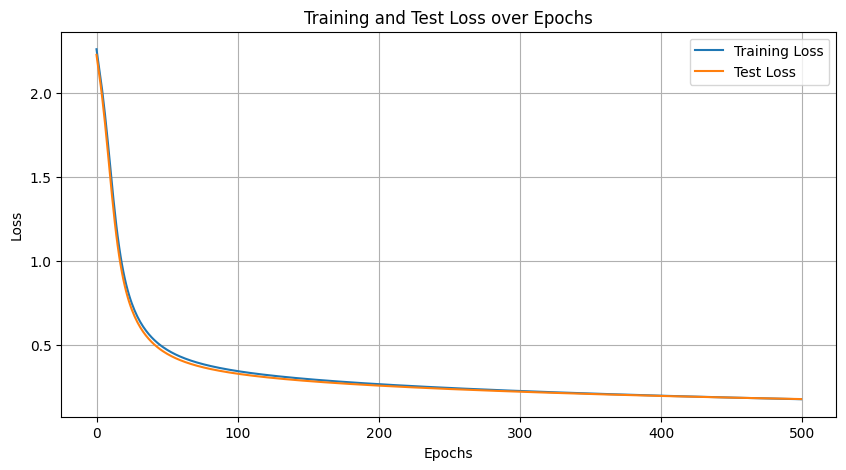

Confusion Matrix:
[[ 964    0    0    1    0    2    8    3    2    0]
 [   0 1111    3    2    1    1    3    2   12    0]
 [   9    4  970    9    7    2    8   10   10    3]
 [   1    0   10  957    0   15    1   12   11    3]
 [   1    1    5    0  932    0    9    3    5   26]
 [  10    2    1   24    1  813   15    3   15    8]
 [  10    3    6    2   10    9  915    0    2    1]
 [   2    9   20    4    4    1    0  963    4   21]
 [   5    2    4   13    5    8   11   10  913    3]
 [   8    7    1    9   24    7    1   14    6  932]]
(10000,)

--- 클래스별 상위 3개 예측 --- (모델이 각 숫자로 가장 확신하는 이미지들)


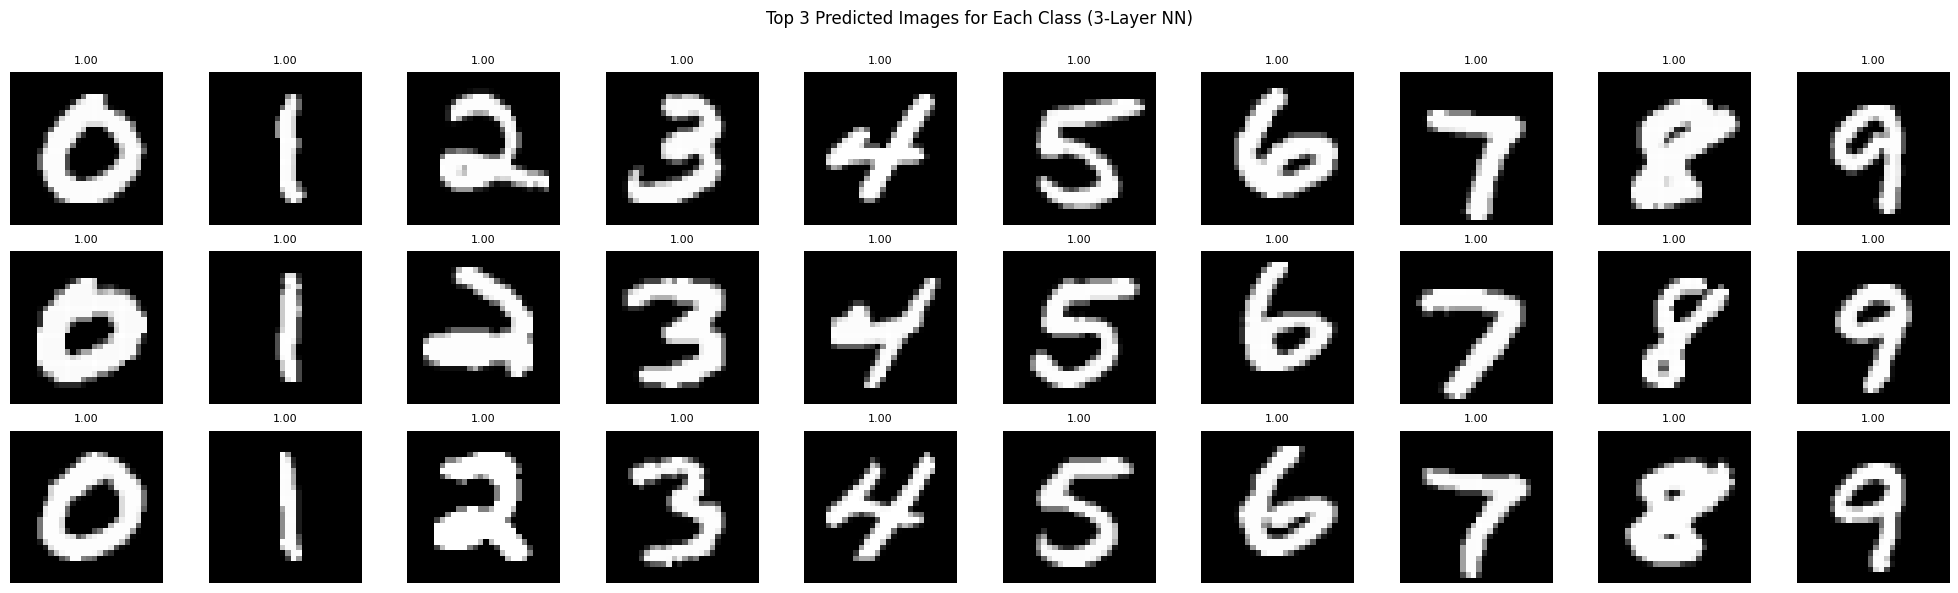

In [9]:
plot_loss(train_losses, test_losses)
conf_matrix = confusion_matrix(pred, gt, num_class=10)

# Load test data again to show predictions
test_images = []
test_labels = []
for image, label in test_loader:
    test_images.extend(image)
    
    label = np.argmax(label, axis=1)
    test_labels.extend(label)
    

test_images = np.concatenate(test_images, axis=0)
test_labels = np.array(test_labels)
print(test_labels.shape)
print("\n--- 클래스별 상위 3개 예측 --- (모델이 각 숫자로 가장 확신하는 이미지들)")
get_top3(pred, test_images, test_labels, num_class=10)